# Preliminary Data Analyses

Now it's time to see how each of the predictor variables in the dataset relate to the response variable of shark density. THe following analyses will have 0s removed.

In [1]:
# Import relevant packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import scipy
import statsmodels.formula.api as smf 

In [2]:
# Read in the dataset and do some quick data cleanup.
dat = pd.read_csv('D:/Documents/SpringBoard/capstone-1/datasets/final_files/combined/'
                  'filled/jackknifed_counts.csv', 
                 parse_dates=['Date']) 

dat['Receiver_D'] = dat['Receiver_D'].astype('category') # turn receiver D into a category
    # for analyses and plotting
dat['Year'] = dat['Year'].astype('category') # turn into a category
dat['Transmitter'] = pd.to_numeric(dat['Transmitter'], errors='coerce') # and make
    # sure that the 'Transmitter' (shark density) is numeric
    
dist_plot_data = dat.loc[:,:] # to plot the distributions of data next to the relationship
    # plots
    
dat = dat[dat['Transmitter'] > 0].reset_index(drop=True) # Let's remove the 0s so that we can run the analyses
    # properly.
dat['Receiver_D'] = dat['Receiver_D'].cat.remove_unused_categories()

In [3]:
# For easier saving to clear/white plots
def background_change(bgcolor): 
    """ Changes the plot defaults so that it shows up nicely with """
    """ either a black or white background                        """
    global boxprops, lineprops, flierprops, boxplot_kwargs, other_cols
        # create global variables
    if bgcolor == 'black': # if the color specified is black
        plt.rc_context({'axes.edgecolor':'white', 'xtick.color':'white',
                        'ytick.color':'white', 'axes.labelcolor':'white'})
            # change all characteristic plot colors to white
        boxprops = {'edgecolor': 'w'} # boxplot colors to white
        lineprops = {'color': 'w'} # boxplot lines to white
        flierprops = dict(markerfacecolor='w', markeredgecolor='w')
            # boxplot fliers (outliers) to white
        other_cols = 'white' # and other colors to white
    if bgcolor == 'white': # if the color specified is black
        plt.rc_context({'axes.edgecolor':'k', 'xtick.color':'k', 
                        'ytick.color':'k', 'axes.labelcolor':'k'})
            # change all characteristic plot colors to black 
        boxprops = {'edgecolor': 'k'} # change boxplot colors to black
        lineprops = {'color': 'k'} # change boxplot lines to black
        flierprops = dict(markerfacecolor='k', markeredgecolor='k')
            # boxplot fliers (outliers) to black
        other_cols = 'black' # other colors to black
    boxplot_kwargs = dict({'boxprops': boxprops, 'medianprops': lineprops,
                       'whiskerprops': lineprops, 'capprops': lineprops})
        # update the kwargs

### Shark Density vs Receiver Density

We have decided to make Receiver Density a categorical parameter so that we can see if receiver density actually significantly influences the number of sharks that are detected.

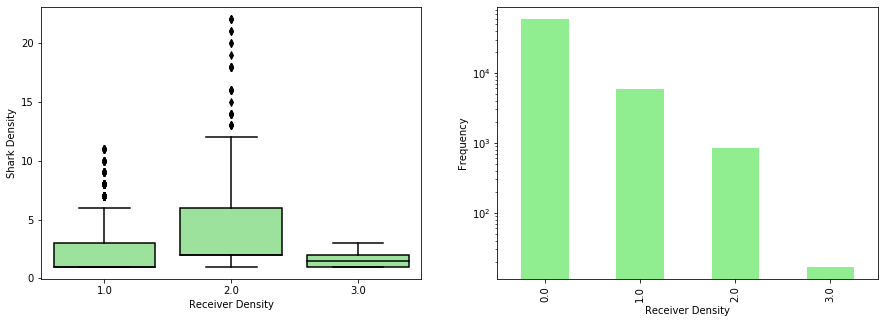

In [4]:
%matplotlib inline 

background_change('white') # change background color for nice plotting

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5)) # we're going to make
    # a two panel figure so that we can display the relationship and the underlying
    # distribution of data. 
    
sns.boxplot(x='Receiver_D', y='Transmitter', data=dat, color='lightgreen', ax=ax1, 
          **boxplot_kwargs, flierprops=flierprops)
    # Let's look at the boxplot
ax1.set_xlabel('Receiver Density') # fix the x
ax1.set_ylabel('Shark Density') # fix the y

# We should also plot the distribution of receiver data for reference
r_counts = pd.DataFrame(dist_plot_data['Receiver_D'].value_counts()).reset_index()
    # get value counts for each receiver density and reset the index
r_counts.columns = ['Receiver_D', 'Frequency'] # rename the columns
r_counts.plot.bar(x='Receiver_D', y='Frequency', logy=True, color='lightgreen', 
                  legend=False, ax=ax2) # plot on the logy scale
ax2.set_xlabel('Receiver Density') # label the x
ax2.set_ylabel('Frequency') # label the y
plt.show() # show the plot
#plt.savefig('D:/Documents/SpringBoard/capstone-1/Preliminary_Analyses/receiver_D.png', dpi=600, transparent=True)

So, it looks like there's a sweet spot where more sharks are detected when 2 receivers are in the water. This is probably due to the fact that there are more instances of 2 receivers compared to 3 receivers in a zone at one time, which can be seen by the distribution plot on the right.

Let's see how these two variables interact using an ANOVA.

In [5]:
# Format data for the ANOVA.
receivers = dat.loc[:,['Receiver_D', 'Transmitter']] # only keep the relevant columns
receivers.loc[:,'intercept'] = 1 # add a null hypothesis that the intercept value is 0
receivers[['one', 'two', 'three']] = pd.get_dummies(receivers.loc[:,'Receiver_D'])
    # add a matrix of dummy values to indicate the presence of each unique
    # receiver density category

receiver_ols = sm.OLS(receivers.loc[:,'Transmitter'],receivers.loc[:,['intercept','two','three']])
    # we want to use ordinary least squares
results_receiver = receiver_ols.fit() # fit the model to the data

In [6]:
# Let's look at the results
results_receiver.summary() # get a summary of the results

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Transmitter   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     254.0
Date:                Tue, 07 Jan 2020   Prob (F-statistic):          1.20e-104
Time:                        14:27:36   Log-Likelihood:                -9130.6
No. Observations:                4042   AIC:                         1.827e+04
Df Residuals:                    4039   BIC:                         1.829e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      2.1299      0.040     53.676      0.000       2.052       2.208
two            2.2694      0.101     22.524      0.000       2.072       2.467
three         -0.4632      0.947     -0.489      0.625      -2.320       1.393
==============================================================================
Omnibus:                     2197.855   Durbin-Watson:                   1.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            20417.982
Skew:                           2.441   Prob(JB):                         0.00
Kurtosis:                      12.869   Cond. No.                         26.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

These results indicate that there is a significant differents between how many sharks are detected in a zone when 2 receivers are deployed compared to when one, or three are deployed. This is a little troubling, because it seems like the probability of a true detection might be dependent on how many receivers are in the water. Although this makes sense (more receivers in a zone likely indicate a greater % coverage within that grid cell) it introduces an artifact into our dataset. Along the same lines, we would expect to see even more sharks with 3 receivers in the water. However, the reason we don't see this relationship may be two fold: 1) The % coverage of a single grid cell may not signifcantly increase when a third receiver is added; and/or 2) There are few instances of when > 2 receivers are actually deployed within a single grid.

### Shark Density vs Year

We want to see if there's a difference in the shark density across years. Maybe some years sharks are more active than others. Perhaps they're using the southern California area every two or three years, as opposed to every year. In this case, year is also a category, so we're going to perform another ANOVA.

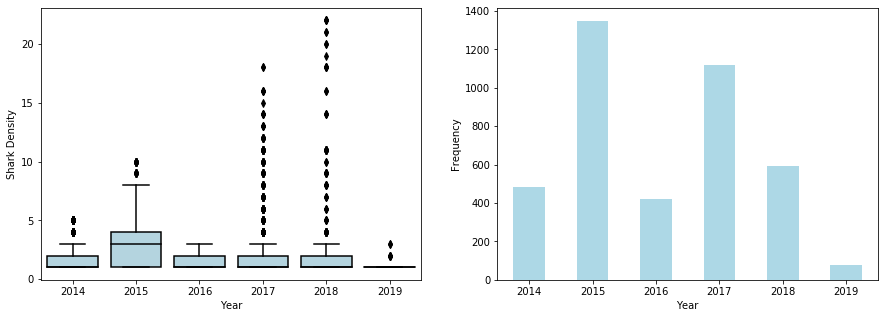

In [7]:
# First, lets plot the data.
%matplotlib inline 

background_change('white') # change background color for nice plotting

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5)) # we're going to make
    # a two panel figure so that we can display the relationship and the underlying
    # distribution of data. 

sns.boxplot(x='Year', y='Transmitter', data=dat, color='lightblue', ax=ax1, 
           **boxplot_kwargs, flierprops=flierprops) # boxplot
ax1.set_xlabel('Year') # add xlabel
ax1.set_ylabel('Shark Density') # add ylabel

# Plot the distribution next to it
peryear = dist_plot_data.loc[dist_plot_data['Transmitter'] > 0, ['Transmitter','Year']].groupby('Year').agg('count')
    # count the number of transmitters > 0 each year
peryear.plot(kind='bar', legend=False, ax=ax2, rot=0, color='lightblue') # plot it
ax2.set_ylabel('Frequency') # fix ylabel
plt.show() # show plot
#plt.savefig('D:/Documents/SpringBoard/capstone-1/Preliminary_Analyses/year_white.png', dpi=600, transparent=True)

From this plot, it looks like most of the years have the same IQR - except for maybe 2015. 2017 and 2018 have a lot of data outside of the IQR, but the majority of the rest of the values during these years may not be so different. Let's run an ANOVA to see.

In [8]:
yearly = dat.loc[:,['Year', 'Transmitter']] # only keep the relevant data

# Get the data ready for the anova
yearly.loc[:,'intercept'] = 1 # set the intercept to 1
yearly[['2014', '2015', '2016', '2017', '2018', '2019']] = pd.get_dummies(yearly.loc[:,'Year'])
    # and run the dummy to get a matrix for years

# Run the ANOVA
year_ols = sm.OLS(yearly.loc[:,'Transmitter'], yearly.loc[:,['intercept', '2015', 
                                                             '2016', '2017', '2018', '2019']])
    # another OLS
results_year = year_ols.fit() # fit the data

# And print out the results
results_year.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Transmitter   R-squared:                       0.053
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     45.57
Date:                Tue, 07 Jan 2020   Prob (F-statistic):           6.25e-46
Time:                        14:27:37   Log-Likelihood:                -9259.0
No. Observations:                4042   AIC:                         1.853e+04
Df Residuals:                    4036   BIC:                         1.857e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.7769      0.109     16.336      0.000       1.564       1.990
2015           1.3448      0.127     10.606      0.000       1.096       1.593
2016          -0.2282      0.159     -1.431      0.153      -0.541       0.084
2017           0.7258      0.130      5.576      0.000       0.471       0.981
2018           0.6167      0.147      4.206      0.000       0.329       0.904
2019          -0.6470      0.294     -2.204      0.028      -1.223      -0.071
==============================================================================
Omnibus:                     2804.608   Durbin-Watson:                   1.130
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            44377.750
Skew:                           3.164   Prob(JB):                         0.00
Kurtosis:                      17.948   Cond. No.                         9.53
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Compared to 2014, there are significantly more sharks in 2015, 2017, and 2018. In 2016, there are around the same number of sharks compared to 2014, and in 2019, there are significantly less sharks. The result for 2019 is likely due to a limited dataset; 2019 is not over yet.

### Shark Density vs Temperature

One hypothesis is that juvenile white shark movement is based on temperatures; baby white sharks are not very efficient at regulating their own body temperatures yet. Let's see how the relationship between shark density and sea surface temperature looks.

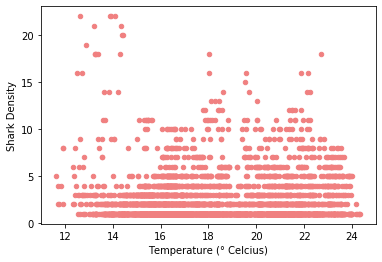

In [9]:
background_change('white') # change background color for nice plotting
dat.plot(x='TempC', y='Transmitter', kind='scatter', color='lightcoral')
    # let's do a scatter plot to see if there's a linear relationship that we can see
plt.xlabel('Temperature (\N{DEGREE SIGN} Celcius)') # fix xlabel
plt.ylabel('Shark Density') # fix ylabel
plt.show() # show plot
#plt.savefig('D:/Documents/SpringBoard/capstone-1/Preliminary_Analyses/temp_all_white.png', dpi=600, transparent=True)

It's no secret that this data looks very messy and would show a non-significant value if we ran a correlation test. Let's first try to figure out whether this is the true distribution of data, or whether something (like year) is influincing this relationship.

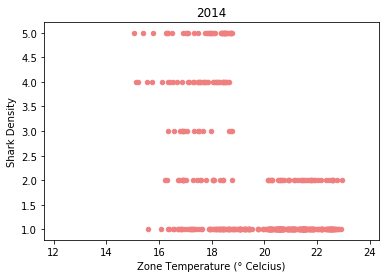

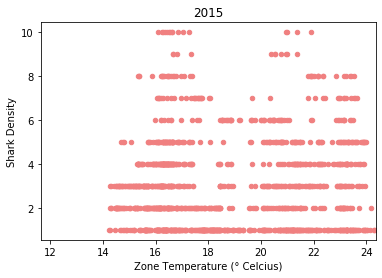

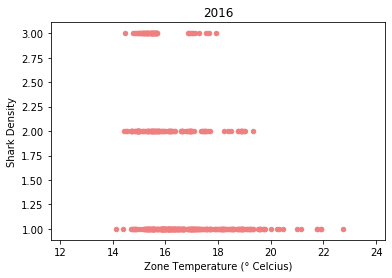

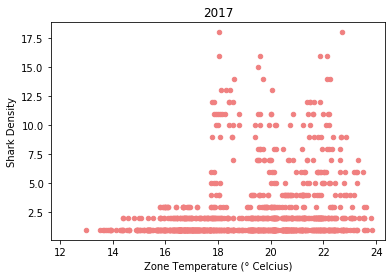

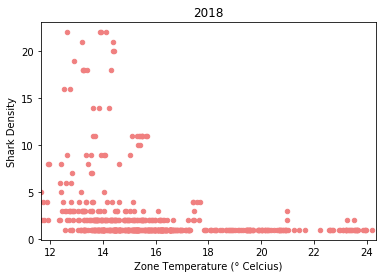

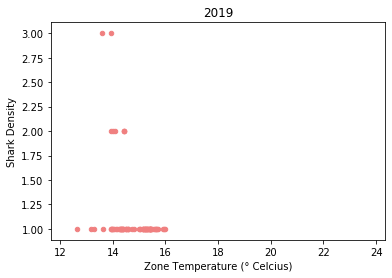

In [10]:
# Maybe the relationship is driven by different years? 
sst = dat.loc[:,['TempC', 'Transmitter', 'Year']].reset_index(drop=True)
    # let's subset the data to include temperature, shark density and year

background_change('white') # change background color for nice plotting

# And we'll set up a loop so that we can plot each year on its own
for year in sst['Year'].drop_duplicates(): # for each unique year
    sst_temp = sst[sst['Year'] == year] # subset the data that has that year
    sst_temp.plot(x='TempC', y='Transmitter', title=year, xlim=(sst['TempC'].min(), 
                                                                sst['TempC'].max()), 
                  kind='scatter', color='lightcoral')
        # plot the data with the same xlims for each plot, and the title as the year
        # in question
    plt.xlabel('Zone Temperature (\N{DEGREE SIGN} Celcius)') # fix xlab
    plt.ylabel('Shark Density') # fix ylab
    #plt.savefig('D:/Documents/SpringBoard/capstone-1/Preliminary_Analyses/temp_'+str(year)+'_white.png', dpi=600, transparent=True)
    plt.show() # show plot

From this, it appears that there is something that looks like a bi-annual shift where every other year, the sharks are most present in higher temperatures or lower temperatures. This is still a really messy distribution of data even across years though. Maybe we need to alter the way we look at things. What if we look at just shark presence vs shark absence, regardless of how many sharks are actually there.

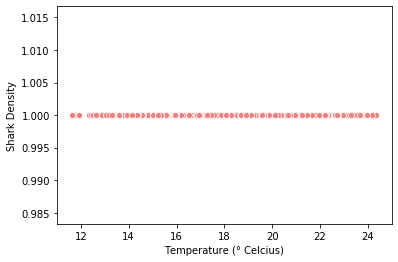

In [11]:
# Lets make a copy of dat so that we can edit the values and see what happens
shark_p = pd.DataFrame(dat, copy=True) # copy dat and save as shark_p (presence)
shark_p['Transmitter'].values[shark_p['Transmitter'].values > 1] = 1
    # any value of shark density that is > 1 is going to receiver the value 1

# Now, we can plot it.
background_change('white') # change background color for nice plotting
sns.scatterplot(x='TempC', y='Transmitter', data=shark_p, color='lightcoral')
plt.xlabel('Temperature (\N{DEGREE SIGN} Celcius)')
plt.ylabel('Shark Density')
plt.show()

This doesn't help us at all! What if instead, we look at the highest number of sharks at each temperature value (we'll round temperatures to 0.1 degrees).

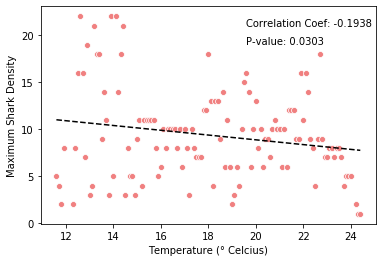

In [12]:
background_change('white')

# First, create a copy dataset so that we can edit it without affecting the true data
rounded = pd.DataFrame(dat, copy=True) # copy

rounded['roundedTempC'] = round(rounded['TempC'], ndigits=1)
    # let's round temperature to the nearest 0.1 and add it as a new column

sst_m = rounded[['Transmitter', 'roundedTempC']].groupby('roundedTempC').agg(max).fillna(0).reset_index()
    # let's create a new dataframe that takes the relevant parameters, groups by the
    # rounded temperature, and shoots out the maximum value for that temperature
    # also, lets fill NAs and reset the index
    
# Regression line for plotting
coefs = np.polyfit(sst_m['roundedTempC'], sst_m['Transmitter'], 1)
    # We're going to be testing a correlation so let's fit a 1st order polynomial to the data
ffit = np.poly1d(coefs) # save the coefficients in 1d
x = np.linspace(sst_m['roundedTempC'].min(), sst_m['roundedTempC'].max(), 100)
    # generate x values
    
# And we'll run a correlation just in case.
ccoef = str(round(scipy.stats.pearsonr(sst_m['Transmitter'], sst_m['roundedTempC'])[0], ndigits=4))
p = str(round(scipy.stats.pearsonr(sst_m['Transmitter'], sst_m['roundedTempC'])[1], ndigits=4))

background_change('white') # change background color for nice plotting
sns.scatterplot(x='roundedTempC', y='Transmitter', data=sst_m, color='lightcoral') # and plot it
plt.plot(x, ffit(x), color=other_cols, linestyle='dashed') # and plot the regression line
plt.text(19.6, 21, 'Correlation Coef: ' + ccoef, color=other_cols)
plt.text(19.6, 19, 'P-value: ' + p, color=other_cols)
plt.ylabel('Maximum Shark Density')
plt.xlabel('Temperature (\N{DEGREE SIGN} Celcius)')
plt.show()
#plt.savefig('D:/Documents/SpringBoard/capstone-1/Preliminary_Analyses/temp_no_corr_white.png', dpi=600, transparent=True)

The correlation p-value is significant (< 0.05), but the correlation coefficient is weak (-0.2). Maybe a different relationship is more suitable. It looks like there are two peaks here: one between 12 and 14 degrees and another between 18 and 22 degrees. Maybe we can model this with a polynomial?

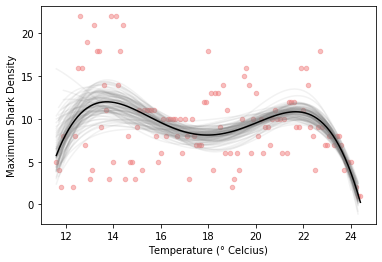

In [13]:
sst_m.plot(x='roundedTempC', y='Transmitter', kind='scatter', color='lightcoral', alpha=0.5)
    # let's replot the data so that we can overlap our model fits
    
# We're going to bootstrap through the data indices and build polynomial functions
# for each bootstrap. Then we're going to plot all of the fitted lines to see where
# we expect the relationship's 'bounds' are.
np.random.seed(33) # let's set a random seed for reproducibility
p_val = [] # empty list to save pvalues

background_change('white') # change background color for nice plotting
for i in range(100): # for 100 iterations
    r_ind = np.random.randint(low=0, high=len(sst_m)-1, size=len(sst_m))
        # randomly sample an index between 0 and the last index value in sst_m
        # randomly sample the same number of values as is in sst_m; this is
        # sampling with replacement
    subs = sst_m.loc[r_ind,:] # now grab the sst_m values that have these
        # indices
    coefs = np.polyfit(subs['roundedTempC'], subs['Transmitter'], 4)
        # fit a 4 dregree polynomial here and save the coefficients
    ffit = np.poly1d(coefs) # now fit the coefficients into a 1d form
    x = np.linspace(subs['roundedTempC'].min(), subs['roundedTempC'].max(), 100)
        # generate 100 values for temperature between the min and the max
    plt.plot(x, ffit(x), color='gray', alpha=0.1) # and plot the fit with a 
        # transparent gray line
    results = smf.ols(formula='Transmitter ~ ffit(roundedTempC)', data=subs).fit()
        # get model results
    p_val.append(results.pvalues[1]) # save iteration pvalue

# Now, let's plot the polynomial function that we get if we use all the data
coefs = np.polyfit(sst_m['roundedTempC'], sst_m['Transmitter'], 4) 
    # fit a 4 degree polynomial here
ffit = np.poly1d(coefs) # save the coefficients into a 1d form
x = np.linspace(sst_m['roundedTempC'].min(), sst_m['roundedTempC'].max(), 100)
    # generate 100 numbers between the min and max temperature
results = smf.ols(formula='Transmitter ~ ffit(roundedTempC)', data=sst_m).fit()
    # get model results
p_val_all = results.pvalues[1] # keep main p-value
plt.plot(x, ffit(x), color=other_cols) # add this line in black
plt.ylabel('Maximum Shark Density') # ylabel
plt.xlabel('Temperature (\N{DEGREE SIGN} Celcius)') # xlabel
plt.show()  # and show
#plt.savefig('D:/Documents/SpringBoard/capstone-1/Preliminary_Analyses/temp_poly_white.png', dpi=600, transparent=True)

In [14]:
# Find the average and standard deviation for p-values from bootstrap
p_val = pd.to_numeric(p_val)
print('Bootstrap p-values: ' + str(scipy.stats.describe(p_val)))
print('')

# And find the value from using all the data
print('All Data p-values: ' + str(p_val_all))

Bootstrap p-values: DescribeResult(nobs=100, minmax=(1.964757992978338e-14, 0.0016669563824429042), mean=3.05241757916945e-05, variance=2.8696844949289745e-08, skewness=9.192633200100522, kurtosis=85.91967834104088)

All Data p-values: 3.45316736676679e-07


In [15]:
ffit

poly1d([-1.31035551e-02,  9.32247025e-01, -2.44563534e+01,  2.79995225e+02,
       -1.16924862e+03])

This might fit the data quite nicely (p < 0.05). We see at the first peak, there's a bit more variation in our model runs. I think this is because the some years, the data were skewed so that more sharks were present in colder temperatures. However, we see that it does, indeed, seem to get too hot for some sharks, as temperatures increase beyond 22 degrees. However, this typically isn't the best method for analyses because it takes the maximum (extreme) values from a dataset. We really want to see whether there is a difference between temperatures when sharks are present compared to when they're absent. See the other Jupyter Notebook (Presence vs Absence) for these analyses.

### Shark Density vs Sea Surface Salinity

Now let's see what the relationship is between these two variables.

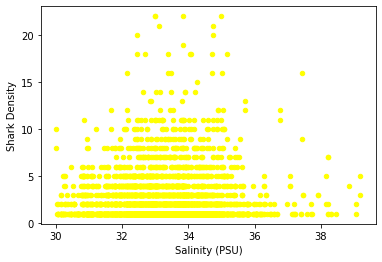

In [16]:
# Let's start by plotting it.
background_change('white') # change background color for nice plotting
dat.plot(x='Sal', y='Transmitter', kind='scatter', color='yellow')
plt.xlabel('Salinity (PSU)')
plt.ylabel('Shark Density')
plt.show()
#plt.savefig('D:/Documents/SpringBoard/capstone-1/Preliminary_Analyses/sal_all.png', dpi=600, transparent=True)

It looks like we may have a similar issue to the one we had for sea surface temperature. See Presence v Absence notebook for more analyses.

### Receiver Density vs Chlorophyll-A

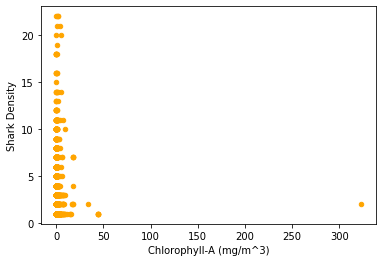

In [17]:
background_change('white') # change background color for nice plotting
dat.plot(x='ChlA', y='Transmitter', color='orange', kind='scatter')
plt.xlabel('Chlorophyll-A (mg/m^3)')
plt.ylabel('Shark Density')
plt.show()
#plt.savefig('D:/Documents/SpringBoard/capstone-1/Preliminary_Analyses/chla_all_white.png', dpi=600, transparent=True)

It looks like we have the same problem here - a large distribution of sharks present. See Presence v Absence notebook for more analyses.

### Shark Density vs Depth Gradient

The depth gradient is how steep the seafloor is in a particular area. One would think that maybe flat areas are more appealing to younger sharks who are still learning to hunt, while steeper areas may be more useful for adult sharks who are trying to ambush their prey.

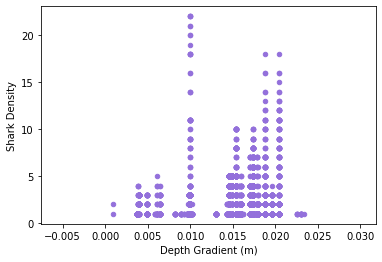

In [18]:
# Start by plotting the data.
background_change('white') # change background color for nice plotting
dat.plot(x='DepthGradient', y='Transmitter', kind='scatter', color='mediumpurple')
plt.xlabel('Depth Gradient (m)')
plt.ylabel('Shark Density')
plt.show()
#plt.savefig('D:/Documents/SpringBoard/capstone-1/Preliminary_Analyses/depth_all_white.png', dpi=600, transparent=True)

This looks more lie a histogram than a distribution of data. And the values for the depth gradient seem to be very small (most of the seafloor appears to be relatively flat). I don't know if we have a wide enough spread of these data values to really be able to tell whether these juvenile white sharks have a preference. Refer to the Presence v Absence notebook for further analyses.

### Shark Density vs Lunar Phase

Many animal movements correspond to different phases of the lunar cycle. Let's see if that's the case here.

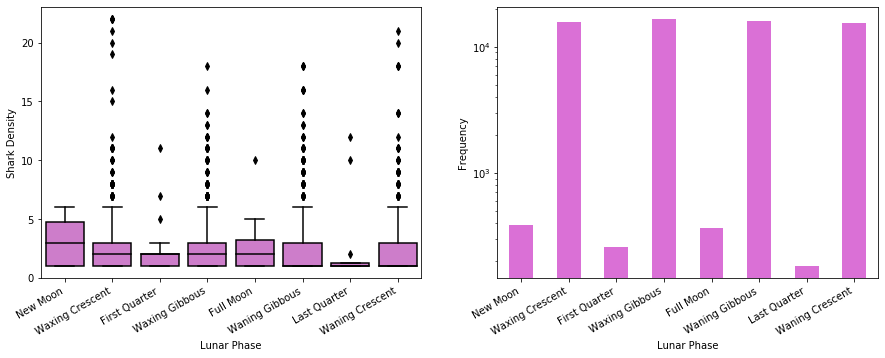

In [19]:
# Plot the data
%matplotlib inline 

col_order = ['NEW_MOON', 'WAXING_CRESCENT', 'FIRST_QUARTER', 'WAXING_GIBBOUS', 
             'FULL_MOON', 'WANING_GIBBOUS', 'LAST_QUARTER', 'WANING_CRESCENT']
    # I want the data to be plotted in the order of the lunar cycle. 
    
background_change('white') # change background color for nice plotting

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,5)) # we're going to make
    # a two panel figure so that we can display the relationship and the underlying
    # distribution of data. 
    
# Begin the boxplot
sns.boxplot(x='MoonPhase', y='Transmitter', data=dat, color='orchid', 
            order=col_order, ax=ax1, **boxplot_kwargs, flierprops=flierprops)
ax1.set_xlabel('Lunar Phase')
ax1.set_xticklabels(['New Moon', 'Waxing Crescent', 'First Quarter', 
                                    'Waxing Gibbous', 'Full Moon', 'Waning Gibbous',
                                    'Last Quarter', 'Waning Crescent'], 
           rotation=30, horizontalalignment ='right')
    # I want the xticks to look nicer (not uppercase text with _) and easier to read (rotated)
ax1.set_ylabel('Shark Density') # ylabel

# We should also plot the distribution for reference
l_counts = pd.DataFrame(dist_plot_data['MoonPhase'].value_counts()).reindex(col_order)
    # get value counts for each phase and reset the index
l_counts.columns = ['Frequency'] # rename the columns
l_counts.plot.bar(y='Frequency', logy=True, color='orchid', 
                  legend=False, ax=ax2, rot=45) # plot on the logy scale
ax2.set_xticklabels(['New Moon', 'Waxing Crescent', 'First Quarter', 
                                    'Waxing Gibbous', 'Full Moon', 'Waning Gibbous',
                                    'Last Quarter', 'Waning Crescent'], 
           rotation=30, horizontalalignment ='right')
ax2.set_xlabel('Lunar Phase') # label the x
ax2.set_ylabel('Frequency') # label the y
plt.show() # show plot
#plt.savefig('D:/Documents/SpringBoard/capstone-1/Preliminary_Analyses/lunar_white.png', dpi=600, transparent=True)

It looks like, in general, all the lunar phases have somewhat similar distributions of data. Let's perform an ANOVA to see if this is truly the case.

In [20]:
# Set up a new dataset for the data to run in the ANOVA
lunar = dat.loc[:,['MoonPhase', 'Transmitter']].reset_index(drop=True)

phaselist = list(lunar.MoonPhase.drop_duplicates().sort_values())
    # there's too many phases to list by hand, so we will just generate
    # the list and sort it alphabetically (that's how get_dummies)
    # sorts it

lunar.loc[:,'intercept'] = 1 # add an intercept to our data

lunar[phaselist] = pd.get_dummies(lunar.loc[:,'MoonPhase'])
    # and get the dummy matrix going for the different lunar phases

int_list = ['intercept'] # we want to add the value 'intercept' to the list
int_list.extend(phaselist[1:]) # add the other phases at the end
    
# Run the OLS
lunar_ols = sm.OLS(lunar.loc[:,'Transmitter'],lunar.loc[:,int_list])
results_lunar = lunar_ols.fit() # and save the results

In [21]:
# Print the results
results_lunar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Transmitter   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4692
Date:                Tue, 07 Jan 2020   Prob (F-statistic):              0.857
Time:                        14:27:41   Log-Likelihood:                -9368.4
No. Observations:                4042   AIC:                         1.875e+04
Df Residuals:                    4034   BIC:                         1.880e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           2.3043      0.513      4.494      0.000       1.299       3.310
FULL_MOON           0.3457      0.752      0.460      0.646      -1.128       1.820
LAST_QUARTER        0.4457      0.876      0.509      0.611      -1.271       2.163
NEW_MOON            0.6572      0.704      0.934      0.351      -0.723       2.037
WANING_CRESCENT     0.0779      0.519      0.150      0.881      -0.940       1.095
WANING_GIBBOUS      0.2207      0.519      0.425      0.671      -0.796       1.238
WAXING_CRESCENT     0.1835      0.519      0.354      0.724      -0.834       1.200
WAXING_GIBBOUS      0.2013      0.518      0.388      0.698      -0.815       1.217
==============================================================================
Omnibus:                     2681.092   Durbin-Watson:                   1.070
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            35752.677
Skew:                           3.037   Prob(JB):                         0.00
Kurtosis:                      16.244   Cond. No.                         43.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

It seems like there's no significant difference in shark density across the different lunar cycles.

### Shark Density vs Zone ID

The last thing we should look at is whether particular zones tend to have more or less sharks. Zones are categories, so we'll do a boxplot and an ANOVA.

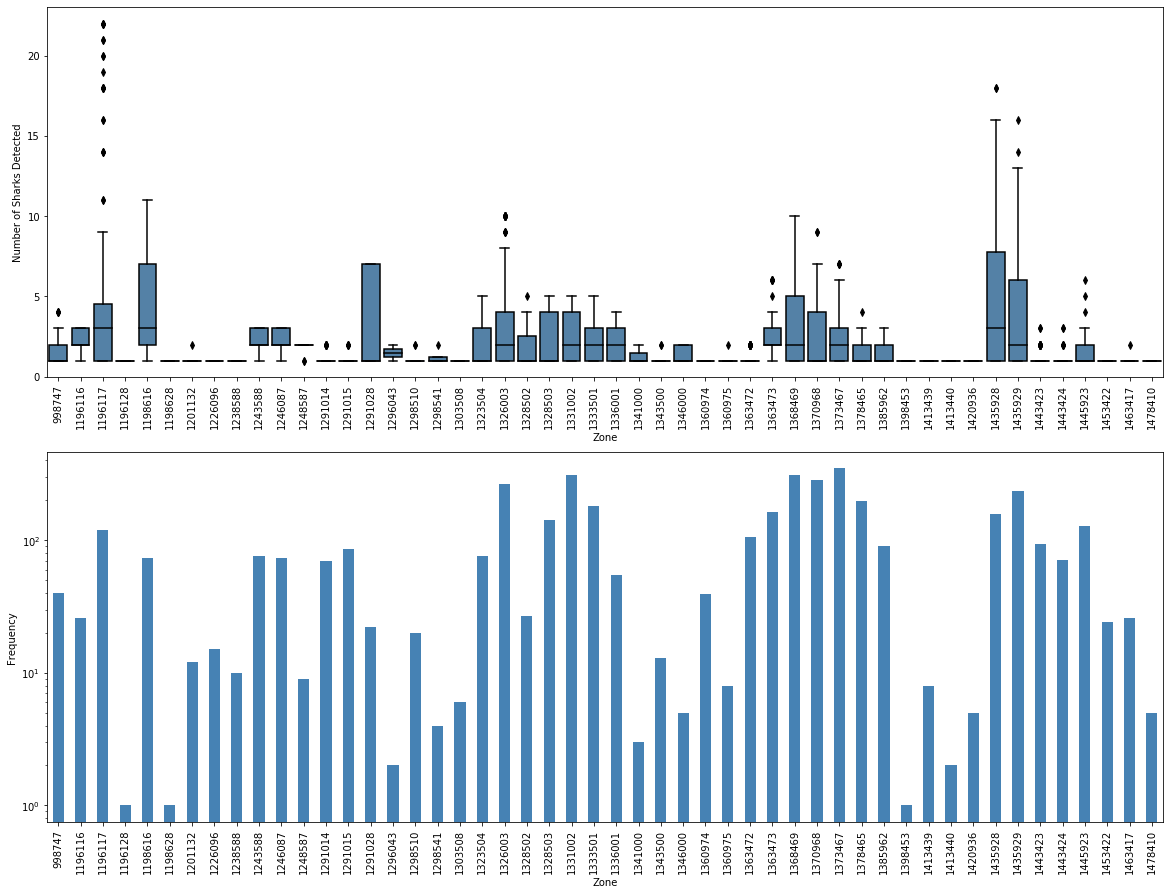

In [22]:
# Make a nice long plot

background_change('white') # change background color for nice plotting

fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(20,15)) # we're going to make
    # a two panel figure so that we can display the relationship and the underlying
    # distribution of data. 
sns.boxplot(x='Zone', y='Transmitter', data=dat, ax=ax1, color='steelblue', 
           **boxplot_kwargs, flierprops=flierprops)
ax1.set_xlabel('Zone')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90) # rotate the xaxis
ax1.set_ylabel('Number of Sharks Detected')
#plt.show()

# We should also plot the distribution  for reference
z_counts = pd.DataFrame(dat['Zone'].value_counts()).reindex(list(dat['Zone'].drop_duplicates().sort_values().reset_index(drop=True)))
    # get value counts for each and reset the index
z_counts.columns = ['Frequency'] # rename the columns
z_counts.plot.bar( y='Frequency', logy=True, color='steelblue', 
                  legend=False, rot=90, ax=ax2) # plot on the logy scale
ax2.set_xlabel('Zone') # label the x
ax2.set_ylabel('Frequency') # label the y
plt.show() # show the plot
#plt.savefig('D:/Documents/SpringBoard/capstone-1/Preliminary_Analyses/zones_white.png', dpi=600, transparent=True)

It does look like some of theze sones have higher values than others. Let's see what the ANOVA says.

In [23]:
# Create our own new dataset
zones = dat.loc[:,['Zone', 'Transmitter']]

# There are so many zones we want to come up with our own sorted list
zonelist = list(zones.Zone.drop_duplicates().sort_values())

zones.loc[:, 'intercept'] = 1 # set the null intercept

zones[zonelist] = pd.get_dummies(zones['Zone']) # and set up the dummy matrix

int_list = ['intercept'] # create a new list with the intercept
int_list.extend(zonelist[1:]) # and add the zone list to it

zone_ols = sm.OLS(zones['Transmitter'],zones[int_list])
    # run the OLS
results_zone = zone_ols.fit() # and get the fit

In [24]:
# Finally, get the results
results_zone.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Transmitter   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.181
Method:                 Least Squares   F-statistic:                     19.17
Date:                Tue, 07 Jan 2020   Prob (F-statistic):          2.97e-146
Time:                        14:27:43   Log-Likelihood:                -8943.1
No. Observations:                4042   AIC:                         1.799e+04
Df Residuals:                    3992   BIC:                         1.830e+04
Df Model:                          49                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.8000      0.352      5.116      0.000       1.110       2.490
1196116        0.3538      0.561      0.631      0.528      -0.745       1.453
1196117        3.4185      0.407      8.406      0.000       2.621       4.216
1196128       -0.8000      2.253     -0.355      0.723      -5.217       3.617
1198616        2.6110      0.438      5.965      0.000       1.753       3.469
1198628       -0.8000      2.253     -0.355      0.723      -5.217       3.617
1201132       -0.7167      0.732     -0.979      0.328      -2.153       0.719
1226096       -0.8000      0.674     -1.187      0.235      -2.121       0.521
1238588       -0.8000      0.787     -1.017      0.309      -2.342       0.742
1243588        0.4368      0.435      1.005      0.315      -0.415       1.289
1246087        0.5378      0.437      1.232      0.218      -0.318       1.394
1248587       -0.0222      0.821     -0.027      0.978      -1.632       1.587
1291014       -0.6714      0.441     -1.522      0.128      -1.536       0.193
1291015       -0.7419      0.426     -1.742      0.082      -1.577       0.093
1291028        1.4273      0.591      2.417      0.016       0.269       2.585
1296043       -0.3000      1.612     -0.186      0.852      -3.461       2.861
1298510       -0.7000      0.609     -1.149      0.251      -1.895       0.495
1298541       -0.5500      1.167     -0.471      0.637      -2.838       1.738
1303508       -0.8000      0.974     -0.821      0.412      -2.710       1.110
1323504        0.2526      0.435      0.581      0.561      -0.600       1.105
1326003        1.4970      0.377      3.967      0.000       0.757       2.237
1328502        0.0519      0.554      0.094      0.925      -1.035       1.138
1328503        0.2775      0.398      0.697      0.486      -0.503       1.058
1331002        0.6613      0.374      1.769      0.077      -0.072       1.394
1333501        0.3333      0.389      0.857      0.392      -0.429       1.096
1336001        0.0727      0.462      0.157      0.875      -0.834       0.979
1341000       -0.4667      1.332     -0.350      0.726      -3.078       2.145
1343500       -0.6462      0.710     -0.910      0.363      -2.039       0.747
1346000       -0.4000      1.055     -0.379      0.705      -2.469       1.669
1360974       -0.8000      0.501     -1.598      0.110      -1.782       0.182
1360975       -0.6750      0.862     -0.783      0.434      -2.365       1.015
1363472       -0.6095      0.413     -1.474      0.140      -1.420       0.201
1363473        0.7521      0.393      1.916      0.055      -0.018       1.522
1368469        1.5701      0.374      4.199      0.000       0.837       2.303
1370968        0.8021      0.376      2.134      0.033       0.065       1.539
1373467        0.3034      0.371      0.817      0.414      -0.425       1.032
13

In [25]:
# Ok so which of these are actually significant?
sigs = pd.DataFrame(results_zone.params[results_zone.pvalues < 0.05]) 
sigs.columns = ['ParameterEstimate']
sigs['p'] = (results_zone.pvalues[results_zone.pvalues < 0.05]) 
print(sigs)

           ParameterEstimate             p
intercept           1.800000  3.264356e-07
1196117             3.418487  5.835554e-17
1198616             2.610959  2.661809e-09
1291028             1.427273  1.571286e-02
1326003             1.496992  7.402844e-05
1368469             1.570130  2.745355e-05
1370968             0.802113  3.286279e-02
1435928             3.098734  4.611650e-15
1435929             1.900422  6.090908e-07


In [26]:
len(zonelist)

50

This table is pretty beefy, because there are so many different zones. However, it looks like ~8 zones have significantly different shark densities compared to their other counterparts. Looking at the printout, it also appears that a lot of these zones are close to one another. My guess is that zones with higher estimated parameters represent 'hotspot' beaches where juvenile white sharks have spent their time in the past. These zones correspond to regions in Santa Barbara, Santa Monica Bay, Long Beach, and Dana Point. Each of these zones has had designated 'hotspots' in previous years. 